In [16]:
from mdml.TrajectoryTools import LoadTrajectories, ParseTrajectory
from mdml.Statistics import RMSD, rmsf

import matplotlib.pyplot as plt
import nglview as nv
import numpy as np

In [18]:
# Load trajectories
trajs = LoadTrajectories().traj_from_dir('/martini/stylianos/ERGF2/data')
trajs

Found 2 trajectories:


{'inactive': <Universe with 5241 atoms>, 'active': <Universe with 5232 atoms>}

In [4]:
inactive = trajs['inactive']
active = trajs['active']

In [5]:
view1 = nv.show_mdanalysis(active)
view2 = nv.show_mdanalysis(inactive)

In [6]:
from ipywidgets.widgets import Box

Box(children=(view1,view2))

Box(children=(NGLWidget(max_frame=165000), NGLWidget(max_frame=165000)))

## Extracting full trajectories and aligning them

In [7]:
# selection = 'name CA and resid 705-1010'

Xi= ParseTrajectory('inactive', inactive.select_atoms('name CA')).allign()
Xa= ParseTrajectory('active', active.select_atoms('name CA')).allign()

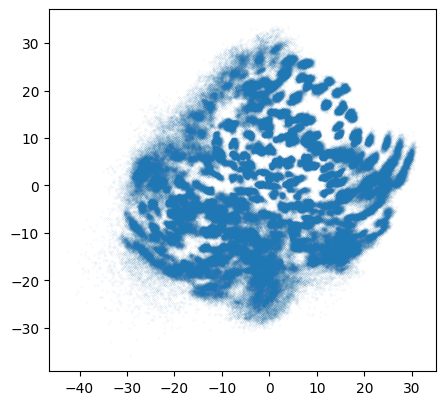

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
fig = plt.scatter(*Xa[::100, :, :2].reshape((-1, 2)).T , s=.001)

ax.set_aspect('equal')
plt.show()

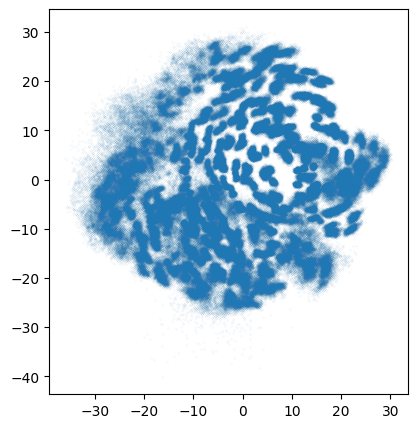

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
fig = plt.scatter(*Xi[::100, :, :2].reshape((-1, 2)).T, s=.001)


ax.set_aspect('equal')
plt.show()

## Calculate RMSDs

In [10]:
rmsd_a_vs_a = RMSD(Xa).calculate_rmsd(Xa) 
rmsd_a_vs_i = RMSD(Xa).calculate_rmsd(Xi) 

rmsd_i_vs_i = RMSD(Xi).calculate_rmsd(Xi) 
rmsd_i_vs_a = RMSD(Xi).calculate_rmsd(Xa)

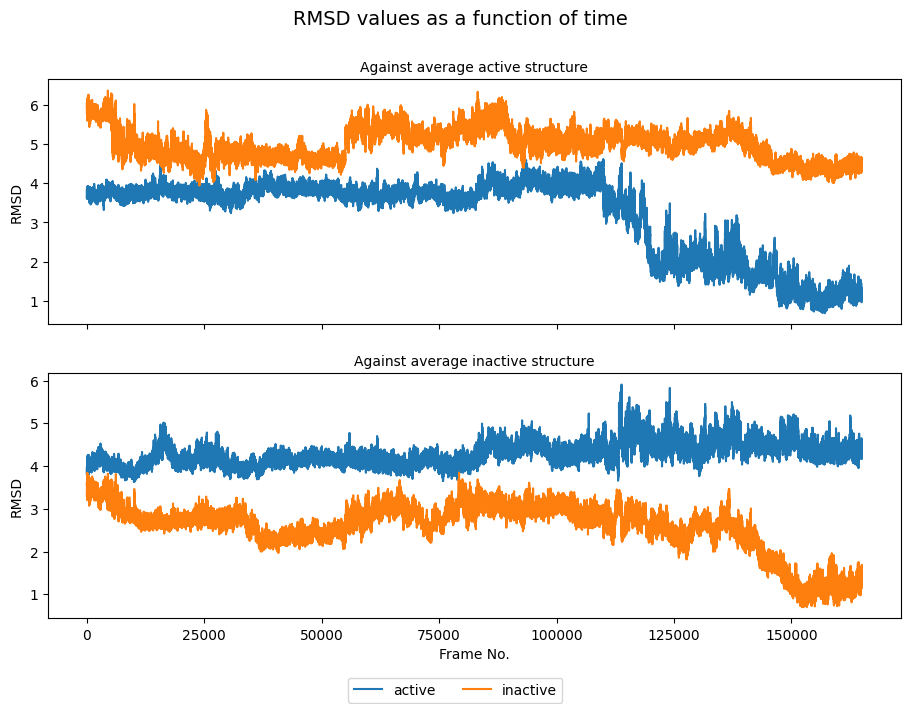

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(11,7))
fig.suptitle('RMSD values as a function of time', fontsize = 14)

ax[0].set_title("Against average active structure", fontsize = 10)
ax[0].plot(np.arange(len(Xa)), rmsd_a_vs_a, label = 'active')
ax[0].plot(np.arange(len(Xa)), rmsd_a_vs_i, label = 'inactive')

ax[1].set_title("Against average inactive structure", fontsize = 10)
ax[1].plot(np.arange(len(Xa)), rmsd_i_vs_a)
ax[1].plot(np.arange(len(Xa)), rmsd_i_vs_i)



plt.figlegend(  loc = 'lower center', 
              borderaxespad=0.1, 
              ncol=4, 
              labelspacing=0.,  
              prop={'size': 10} )

for ax in fig.get_axes():
    ax.set(xlabel='Frame No.',ylabel= 'RMSD')
    ax.label_outer()
plt.savefig('RMSD_both.png')    
plt.show()

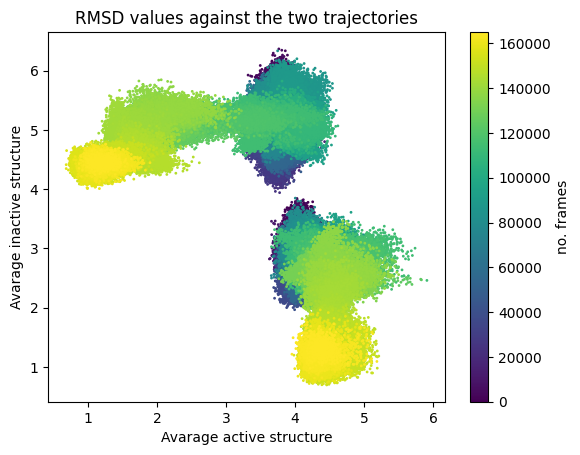

In [12]:
plt.scatter(rmsd_a_vs_a, rmsd_a_vs_i, s=1, c=np.arange(len(Xa)), label = 'active')
plt.scatter(rmsd_i_vs_a, rmsd_i_vs_i, s=1, c=np.arange(len(Xi)), label = 'inactive')
plt.title('RMSD values against the two trajectories')
plt.xlabel('Avarage active structure')
plt.ylabel('Avarage inactive structure')

cbar = plt.colorbar()
cbar.set_label('no. frames')
plt.savefig('RMSD_against.png')
plt.show()

## Calculate RMSF

In [13]:
rmsf_a = rmsf(Xa)
rmsf_i = rmsf(Xi)

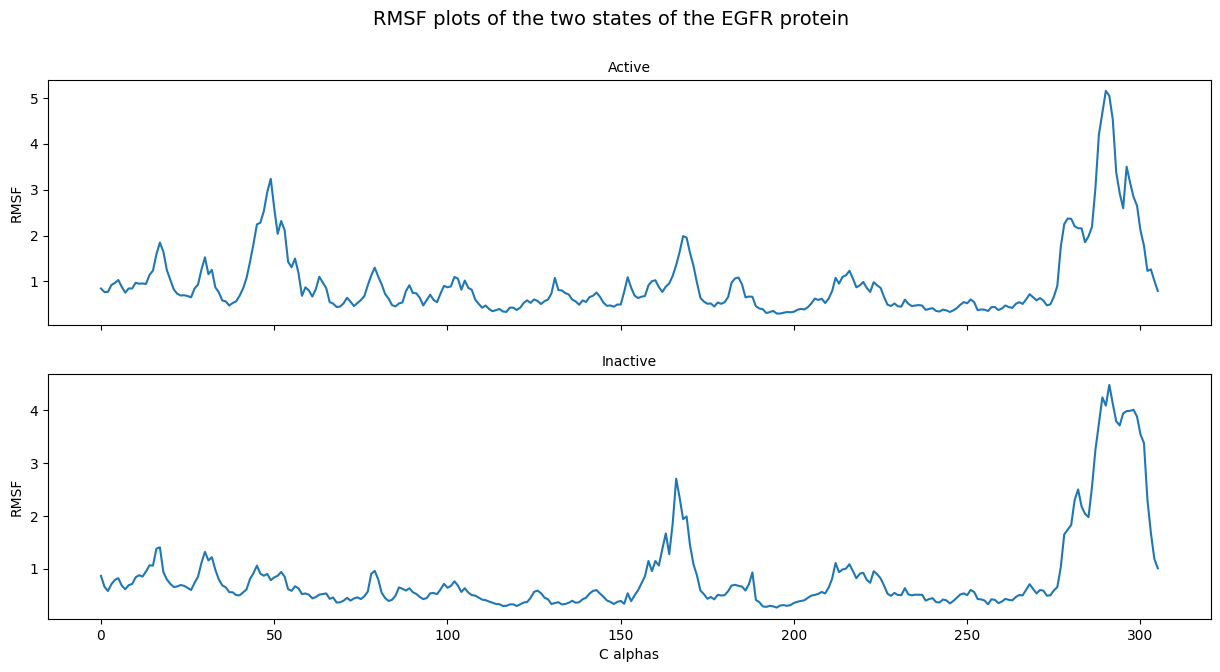

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(15,7))
fig.suptitle('RMSF plots of the two states of the EGFR protein', fontsize = 14)

ax[0].set_title("Active", fontsize = 10)
ax[0].plot(np.arange(len(rmsf_a)), rmsf_a, label = 'active')


ax[1].set_title("Inactive", fontsize = 10)
ax[1].plot(np.arange(len(rmsf_i)), rmsf_i)



for ax in fig.get_axes():
    ax.set(xlabel='C alphas',ylabel= 'RMSF')
    ax.label_outer()
plt.savefig('RMSFs.png')    
plt.show()

## PCA

In [10]:
frames, natoms, dim = Xi.shape

vecXi = Xi.reshape((-1, natoms * dim))
vecXa = Xa.reshape((-1, natoms * dim))

meanXi = vecXi.mean(axis=0)
meanXa = vecXa.mean(axis=0)

# Combined PCA (all trajectories joined)
# --> includes differential in within system effects

totmean = (meanXi + meanXa) / 2 # Same number of frames

vecXi -= totmean
vecXa -= totmean

cov = (vecXi.T @ (vecXi / (2 * len(Xi)))) + (vecXa.T @ (vecXa / (2 * len(Xa)))) 
vals, vecs = np.linalg.eigh(cov)

vals = vals[::-1]
vecs = vecs[:, ::-1]

In [11]:
print('Percentage of total variance per eigenvalue:\n', (vals * 100 / np.sum(vals))[:7], '\n')
print('Cumulative sum:\n', (vals.cumsum() * 100 / np.sum(vals))[:7], '\n')

Percentage of total variance per eigenvalue:
 [38.07676509 24.05200317 12.19052642  4.79432012  3.30708831  2.1148538
  1.42676806] 

Cumulative sum:
 [38.07676509 62.12876826 74.31929468 79.1136148  82.42070311 84.53555692
 85.96232498] 



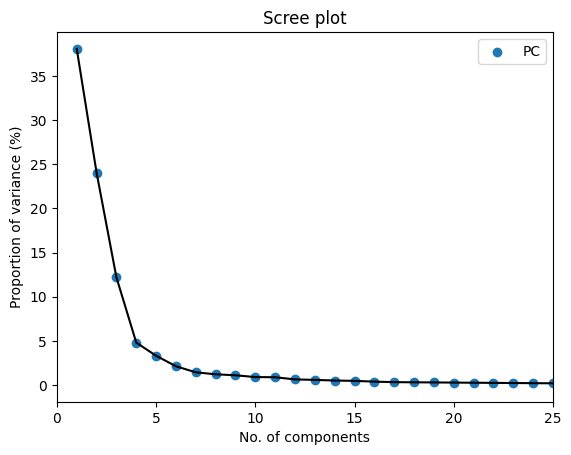

In [12]:
plt.plot(np.arange(len((vals * 100 / np.sum(vals)))) + 1, (vals * 100 / np.sum(vals)), c = 'black')
plt.scatter(np.arange(len((vals * 100 / np.sum(vals)))) + 1, (vals * 100 / np.sum(vals)),  label = 'PC')
plt.title('Scree plot')
plt.ylabel('Proportion of variance (%)')
plt.xlabel('No. of components')
plt.legend()
plt.xlim((0, 25))
plt.savefig('scree_plot.png')
plt.show()

In [13]:
projXi = vecXi @ vecs[:, :5]
projXa = vecXa @ vecs[:, :5]

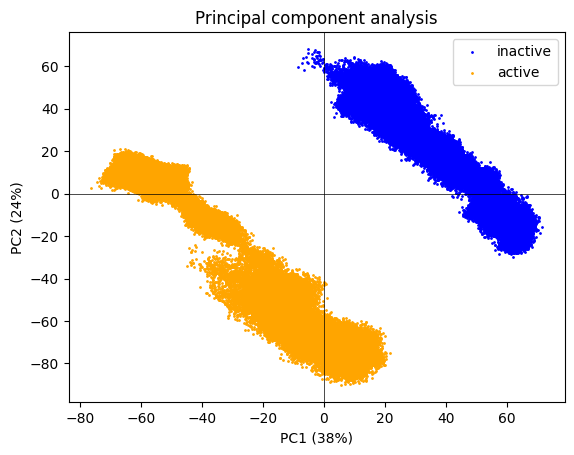

In [15]:
plt.axvline(0, c= 'black', linewidth = 0.5)
plt.axhline(0, c= 'black', linewidth = 0.5)
plt.scatter(*projXi[:, :2].T, s=1, c='blue', label = 'inactive')
plt.scatter(*projXa[:, :2].T, s=1, c='orange', label = 'active')
ax.set_aspect('equal')

plt.title('Principal component analysis')
plt.xlabel('PC1 (38%)')
plt.ylabel('PC2 (24%)')
plt.legend()
plt.savefig('PCA.png')
plt.show()
